Генереруем точки (x и y), лежашие на грифике функции.

Сид для генрерации - 3 числа, каждое от -10 до 10.

In [36]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import keras

In [15]:
def get_y(x):
    return 10 + x*x


def sample_data(n=10000, scale=100):
    data = []

    x = scale*(np.random.random_sample((n,))-0.5)

    for i in range(n):
        yi = get_y(x[i])
        data.append([x[i], yi])

    return np.array(data)

In [32]:
dataset = sample_data()

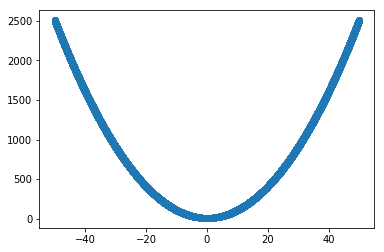

In [33]:
fig = plt.figure()
plt.scatter(dataset[:,0], dataset[:,1])
plt.show()

In [97]:
def make_generator_model():

    model = keras.Sequential()

    model.add(keras.layers.Dense(16, activation=keras.activations.relu, input_shape=(3,)))
    model.add(keras.layers.Dense(16,activation=keras.activations.relu))
    model.add(keras.layers.Dense(2))
    
#     model.add(keras.layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
#     model.add(keras.layers.BatchNormalization())
#     model.add(keras.layers.LeakyReLU())

#     model.add(keras.layers.Reshape((7, 7, 256)))
#     assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

#     model.add(keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
#     assert model.output_shape == (None, 7, 7, 128)
#     model.add(keras.layers.BatchNormalization())
#     model.add(keras.layers.LeakyReLU())

#     model.add(keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
#     assert model.output_shape == (None, 14, 14, 64)
#     model.add(keras.layers.BatchNormalization())
#     model.add(keras.layers.LeakyReLU())

#     model.add(keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
#     assert model.output_shape == (None, 28, 28, 1)

    return model

In [98]:
generator = make_generator_model()

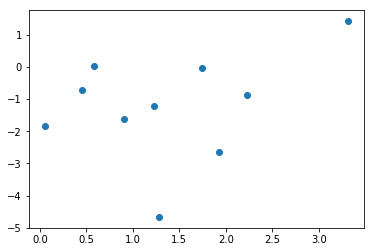

In [118]:
noise = np.random.randint(-10, 10, size=(10, 3))
generated = generator.predict(noise)
fig = plt.figure()
plt.scatter(generated[:,0], generated[:,1])
plt.show()

In [119]:
def make_discriminator_model():
    
    model = keras.Sequential()
    
    model.add(keras.layers.Dense(16, activation=keras.activations.relu, input_shape=(2,)))
    model.add(keras.layers.Dense(16,activation=keras.activations.relu))
    model.add(keras.layers.Dense(2))
    model.add(keras.layers.Dense(1))
    
#     model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
#                                      input_shape=[28, 28, 1]))
#     model.add(layers.LeakyReLU())
#     model.add(layers.Dropout(0.3))

#     model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
#     model.add(layers.LeakyReLU())
#     model.add(layers.Dropout(0.3))

#     model.add(layers.Flatten())
#     model.add(layers.Dense(1))

    return model

In [129]:
discriminator = make_discriminator_model()

In [130]:
descriminator.predict(generated)

array([[0.12844668],
       [0.20216048],
       [0.7155329 ],
       [0.06748088],
       [0.369411  ],
       [0.49838686],
       [0.33399427],
       [0.27253547],
       [0.17547528],
       [0.28395864]], dtype=float32)

In [123]:
# cross_entropy = keras.losses.binary_crossentropy(from_logits=True)

TypeError: binary_crossentropy() got an unexpected keyword argument 'from_logits'

In [148]:
def discriminator_loss(real_output, fake_output):
#     real_loss = keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output)
#     fake_loss = keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
#     total_loss = real_loss + fake_loss
#     return total_loss
    a = tf.nn.sigmoid_cross_entropy_with_logits(logits=real_output, labels=tf.ones_like(real_output))
    b = tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_output, labels=tf.zeros_like(fake_output))
    disc_loss = tf.reduce_mean(a + b)
    return disc_loss

In [149]:
def generator_loss(fake_output):
#     return keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)
    a = tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_output,labels=tf.ones_like(fake_output))
    gen_loss = tf.reduce_mean(a)
    return gen_loss

In [150]:
generator_optimizer = keras.optimizers.Adam(1e-4)
discriminator_optimizer = keras.optimizers.Adam(1e-4)

In [132]:
# checkpoint_dir = './training_checkpoints'
# checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

ValueError: `Checkpoint` was expecting a checkpointable object (an object derived from `CheckpointableBase`), got <keras.engine.sequential.Sequential object at 0x7fdf636f2a20>. If you believe this object should be checkpointable (i.e. it is part of the TensorFlow Python API and manages state), please open an issue.

In [154]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16
BATCH_SIZE = 10000

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = np.random.randint(-10, 10, size=(noise_dim, 3))

In [157]:
def train_step(images):
    noise = np.random.randint(-10, 10, size=(BATCH_SIZE, 3))

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generator_output = generator.predict(noise)
        real_output = discriminator.predict(images)
        fake_output = discriminator.predict(generator_output)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_weights)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_weights)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))



In [158]:
train_step(dataset)

AttributeError: 'RefVariable' object has no attribute '_id'